In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import os

In [9]:
carpeta_pm25 = "Datasets\Datos_SIATA_Aire_pm25.json"

with open(carpeta_pm25, "r", encoding="utf-8") as f:data = json.load(f)

registros = []

        
for estacion in data:
    lat = estacion.get("latitud")
    lon = estacion.get("longitud")
    codigo = estacion.get("codigoSerial")
    nombre = estacion.get("nombre")
    nombreCorto = estacion.get("nombreCorto")
    datos = estacion.get("datos", [])

    for entrada in datos:
        registros.append({
            "codigoSerial": codigo,
            "nombreCorto": nombreCorto,
            "nombre": nombre,
            "latitud": lat,
            "longitud": lon,
            "contaminante": entrada.get("variableConsulta"),
            "fecha": entrada.get("fecha"),
            "calibracion": entrada.get("valor"), # Ojooo esto es calibración 
            "valor": entrada.get("calidad") # Y esto calidad, osea que la calidad se llama valor y la calibración valga la redundancia calibración 
        })

# Convertimos a DataFrame como antes
df = pd.DataFrame(registros)
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
df["calibracion"] = pd.to_numeric(df["calibracion"], errors='coerce')


df.loc[df["calibracion"] == -9999, 'valor'] = np.nan

print(df.head(20))


    codigoSerial nombreCorto                               nombre   latitud  \
0              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
1              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
2              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
3              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
4              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
5              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
6              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
7              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
8              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
9              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
10             3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
11             3    GIR-SOSN  _OFF-Girardota - S.O.S

In [10]:
validos_por_estacion = df.groupby('nombreCorto')['valor'].apply(lambda x: x.notna().mean() * 100)
validos_por_contaminante = df.groupby('contaminante')['valor'].apply(lambda x: x.notna().mean() * 100)
print(f"Porcentaje datos válidos por estación\n{validos_por_estacion}\n\nPorcentaje datos válidos por contaminante{validos_por_contaminante}")

Porcentaje datos válidos por estación
nombreCorto
BAR-TORR    98.322109
BEL-FEVE    99.086862
CAL-JOAR    97.694327
CAL-LASA    57.607579
CEN-TRAF    98.641708
COP-CVID    99.520603
ENV-HOSP    99.337975
EST-HOSP    97.865540
GIR-SOSN     0.022828
ITA-CJUS    99.269490
ITA-CONC    98.915649
MED-ALTA    99.143933
MED-ARAN    99.292318
MED-BEME    99.109691
MED-LAYE    99.611916
MED-SCRI    98.230796
MED-TESO    98.881406
MED-UNNV     0.000000
MED-VILL    99.532017
SAB-RAME    98.459080
SUR-TRAF    97.808469
Name: valor, dtype: float64

Porcentaje datos válidos por contaminantecontaminante
pm25    87.445443
Name: valor, dtype: float64


In [11]:
# Obtener contaminante único (ya que el archivo es solo de uno)
contaminante_unico = df['contaminante'].unique()[0] if not df['contaminante'].isna().all() else "Desconocido"


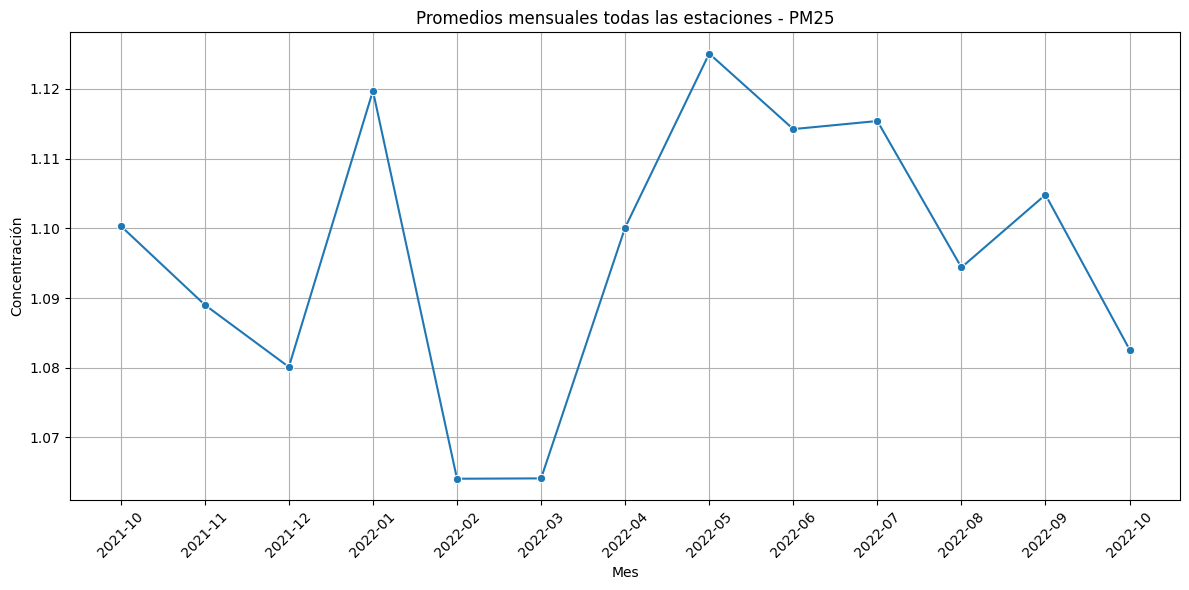

In [12]:
df['mes'] = df['fecha'].dt.to_period("M")
promedios_mensuales = df.groupby('mes')['valor'].mean().reset_index()
promedios_mensuales['mes'] = promedios_mensuales['mes'].astype(str)

# Graficar
plt.figure(figsize=(12,6))
sns.lineplot(data=promedios_mensuales, x='mes', y='valor', marker='o')
plt.title(f'Promedios mensuales todas las estaciones - {contaminante_unico.upper()}')
plt.xlabel('Mes')
plt.ylabel('Concentración')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# 5. Mapa estático de estaciones segun datos validos



# Media por estacion
media_estaciones = df.groupby(['codigoSerial', 'nombre', 'latitud', 'longitud'])['valor'].mean().reset_index()

validos_por_estacion = df.groupby('codigoSerial')['valor'].apply(lambda x: x.notna().mean() * 100)

media_estaciones['porcentaje_validos'] = media_estaciones['codigoSerial'].map(validos_por_estacion)


mapa = folium.Map(location=[6.25, -75.6], zoom_start=11)

for _, row in media_estaciones.iterrows():
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']],
        radius=6,
        popup=(
            f"Estación {row['nombre']}\n"
            f"Media: {row['valor']:.2f}\n"
            f"Válidos: {row['porcentaje_validos']:.1f}%"
        ),
        color = 'green' if row['porcentaje_validos'] >= 51 else 'red',
        fill=True,
    ).add_to(mapa)

mapa

In [ ]:
# mapa por estacion según concentracion de la partícula


# Media por estación
media_estaciones = df.groupby(['codigoSerial', 'nombre', 'latitud', 'longitud'])['valor'].mean().reset_index()

# Porcentaje de datos válidos por estación
validos_por_estacion = df.groupby('codigoSerial')['valor'].apply(lambda x: x.notna().mean() * 100)
media_estaciones['porcentaje_validos'] = media_estaciones['codigoSerial'].map(validos_por_estacion)

# Clasificación de color según niveles de concentración promedio
def color_por_valor(valor):
    if pd.isna(valor):
        return 'gray'
    elif valor < 12:
        return 'green'
    elif valor < 35.4:
        return 'yellow'
    elif valor < 55.4:
        return 'orange'
    else:
        return 'red'

# Crear mapa
mapa = folium.Map(location=[6.25, -75.6], zoom_start=11)

for _, row in media_estaciones.iterrows():
    color = color_por_valor(row['valor'])
    radio = 4 + (row['valor'] / 5) if not pd.isna(row['valor']) else 4
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']],
        radius=radio,
        popup=folium.Popup(
            f"<b>{row['nombre']}</b><br>"
            f"Media: {row['valor']:.2f}<br>"
            f"Válidos: {row['porcentaje_validos']:.1f}%",
            max_width=300
        ),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(mapa)

# Mostrar mapa en notebook
mapa